In [ ]:
!pip install umap-learn hdbscan
!pip install BorutaShap
!pip install xlsxwriter
from BorutaShap import BorutaShap
import umap
import hdbscan
import matplotlib.pyplot as plt

In [ ]:
import random
import numpy as np
import pandas as pd

random.seed(3311791)
np.random.seed(3311791)

In [ ]:
data = {
    'Patent_ID': ['Patent_1', 'Patent_2', 'Patent_3', 'Patent_4'],
    'Text' : [
    'This patent is for a groundbreaking type of li-ion power cell. It employs a fabrication technique for assembly. The power cell utilizes a high-capacity anode, a high-voltage cathode, and a stable electrolyte solution for improved energy density. Unique to this patent is the use of a graphite-based anode which enhances the charge-discharge cycle efficiency.',

    'This patent delineates a unique blueprint for energy module assembly. It also capitalizes on state-of-the-art production techniques. The power cell utilizes a high-capacity anode, a high-voltage cathode, and a stable electrolyte solution for improved energy density. Unique to this patent is the use of a graphite-based anode which enhances the charge-discharge cycle efficiency. The design includes a li-ion power cell with a high-capacity anode, a high-voltage cathode, and a stable electrolyte solution. The energy storage unit also features an advanced battery management system for optimal performance. This patent uniquely introduces a graphite-based anode that significantly improves safety and performance. The energy module incorporates a series of li-ion cells, each with a protective casing and thermal management system. A distinguishing feature of this patent is the lithium cobalt oxide (LiCoO2) cathode that provides high energy density.',

    'This patent involves an innovative design for energy storage unit construction and assembly. It employs a fabrication technique for assembly. The power cell utilizes a high-capacity anode, a high-voltage cathode, and a stable electrolyte solution for improved energy density. Unique to this patent is the use of a graphite-based anode which enhances the charge-discharge cycle efficiency.',

    'This patent elucidates a method for enhancing the architecture of li-ion power pack. It also capitalizes on state-of-the-art production techniques.'
],
    'Company': ['A', 'B', 'C', 'B'],
    'Application.Date': ['2023-01-01', '2022-01-02', '2021-01-03', '2020-01-04'],
    'Country.Code': ['US', 'US', 'JP', 'DE'],
    'Probable.Patent.Assignee': ['Company_A', 'Company_B', 'Company_C', 'Company_B'],
    'Family.Number': ['1', '2', '2', '4'],
    'Title': ['Title_1', 'Title_2', 'Title_3', 'Title_4'],
    'Abstract': ['Abstract_1', 'Abstract_2', 'Abstract_3', 'Abstract_4'],
    'Number.of.Forward.Citations': [8, 1, 2, 0]}

df = pd.DataFrame(data)
df


,Patent_ID,Text,Company,Application.Date,Country.Code,Probable.Patent.Assignee,Family.Number,Title,Abstract,Number.of.Forward.Citations
0,Patent_1,This patent is for a groundbreaking type of li...,A,2023-01-01,US,Company_A,1,Title_1,Abstract_1,8
1,Patent_2,This patent delineates a unique blueprint for ...,B,2022-01-02,US,Company_B,2,Title_2,Abstract_2,1
2,Patent_3,This patent involves an innovative design for ...,C,2021-01-03,JP,Company_C,2,Title_3,Abstract_3,2
3,Patent_4,This patent elucidates a method for enhancing ...,B,2020-01-04,DE,Company_B,4,Title_4,Abstract_4,0


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import words
import re
nltk.download('stopwords')
nltk.download('punkt')
import spacy
nltk.download('words')

english_words = set(words.words())
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
custom_stopwords = {'lithium', 'li', 'ion', 'battery', 'cell', 'said', 'wherein', 'herein', 'one', 'claim', 'claims', 'comprise', 'say', 'first', 'second', 'third'}
stop_words = set(stopwords.words('english')).union(custom_stopwords)
def preprocess(text):
    doc = nlp(text)
    text = " ".join([token.lemma_.lower() for token in doc if token.is_alpha  and token.pos_ in ['NOUN', 'PROPN'] and token.lemma_.lower() not in stop_words]) # lemmatize if alphanumeric and is a noun or proper noun and not in stopwords

    return [word for word in text.split() if len(word) >= 2]


df['Text_Lemma'] = df['Text'].apply(preprocess)

In [ ]:
df[['Patent_ID','Text_Lemma']]

,Patent_ID,Text_Lemma
0,Patent_1,"[patent, type, power, fabrication, technique, ..."
1,Patent_2,"[patent, blueprint, energy, module, assembly, ..."
2,Patent_3,"[patent, design, energy, storage, unit, constr..."
3,Patent_4,"[patent, method, architecture, power, pack, st..."


In [ ]:
df['Text_Lemma_unlist'] = df['Text_Lemma'].apply(' '.join)

In [ ]:
df['Text_Lemma_unlist'][3]

'patent method architecture power pack state art production technique'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3),
     min_df=1, stop_words="english", max_features=250)

tfidf = tfidf_vectorizer.fit_transform(df['Text_Lemma_unlist'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

X_tfidf = tfidf.copy()

X_tfidf[X_tfidf > 0] = 1

doc_coo_tfidf = pd.DataFrame(X_tfidf.todense(), columns=tfidf_feature_names)
pd.concat([df['Patent_ID'], doc_coo_tfidf.astype(int)], axis=1)

,Patent_ID,anode,anode charge,anode charge discharge,anode safety,anode safety performance,anode voltage,anode voltage cathode,architecture,architecture power,...,unit construction,unit construction assembly,unit management,unit management performance,use,use graphite,use graphite anode,voltage,voltage cathode,voltage cathode solution
0,Patent_1,1,1,1,0,0,1,1,0,0,...,0,0,0,0,1,1,1,1,1,1
1,Patent_2,1,1,1,1,1,1,1,0,0,...,0,0,1,1,1,1,1,1,1,1
2,Patent_3,1,1,1,0,0,1,1,0,0,...,1,1,0,0,1,1,1,1,1,1
3,Patent_4,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sum(doc_coo_tfidf.sum()==2)

21

In [ ]:
import itertools

min_patent_cooc = 2
tfidf_df = pd.DataFrame(X_tfidf.todense(), columns=tfidf_feature_names)
control_vars = ['Country.Code', 'Company']

dummy_list = []

for index, row in tfidf_df.iterrows():
    words = row[row > 0].index.tolist()

    # Get all pairs of words
    pairs = list(itertools.combinations(words, 2))

    row_dict = {}

    # For each pair of words, create a new dummy variable
    for pair in pairs:
        # Check if one word is a subgram of the other
        if pair[0] in pair[1] or pair[1] in pair[0]:
            continue

        # Create the name of the dummy variable
        dummy_var_name = f"{pair[0]}+{pair[1]}"

        # Set the value of the dummy variable for this patent to 1
        row_dict[dummy_var_name] = 1

    dummy_list.append(row_dict)

tfidf_dummy = pd.DataFrame(dummy_list)

tfidf_dummy.fillna(0, inplace=True)

# Drop word pairs with few co-occurrences
col_sums = tfidf_dummy.sum()
cols_to_retain = col_sums[col_sums >= min_patent_cooc].index
tfidf_dummy = tfidf_dummy[cols_to_retain]

pd.concat([df['Patent_ID'], tfidf_dummy.astype(int)], axis=1)


,Patent_ID,anode+assembly,anode+assembly power,anode+assembly power capacity,anode+capacity,anode+cathode,anode+cathode solution,anode+cathode solution energy,anode+charge,anode+charge discharge,...,storage unit+voltage,storage unit+voltage cathode,storage unit+voltage cathode solution,technique+unit,unit+use,unit+use graphite,unit+use graphite anode,unit+voltage,unit+voltage cathode,unit+voltage cathode solution
0,Patent_1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Patent_2,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Patent_3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Patent_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.concat([df['Patent_ID'], tfidf_dummy.astype(int)], axis=1)

,Patent_ID,anode+assembly,anode+assembly power,anode+assembly power capacity,anode+capacity,anode+cathode,anode+cathode solution,anode+cathode solution energy,anode+charge,anode+charge discharge,...,storage unit+voltage,storage unit+voltage cathode,storage unit+voltage cathode solution,technique+unit,unit+use,unit+use graphite,unit+use graphite anode,unit+voltage,unit+voltage cathode,unit+voltage cathode solution
0,Patent_1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Patent_2,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Patent_3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Patent_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df[control_vars]

,Country.Code,Company
0,US,A
1,US,B
2,JP,C
3,DE,B


In [ ]:
# merge control with cooccurrence dummies
control_dummies = pd.get_dummies(df[control_vars])
tfidf_cooc_control_dummy = pd.concat([control_dummies, tfidf_dummy, df['Number.of.Forward.Citations']], axis=1)
tfidf_cooc_control_dummy

,Country.Code_DE,Country.Code_JP,Country.Code_US,Company_A,Company_B,Company_C,anode+assembly,anode+assembly power,anode+assembly power capacity,anode+capacity,...,storage unit+voltage cathode,storage unit+voltage cathode solution,technique+unit,unit+use,unit+use graphite,unit+use graphite anode,unit+voltage,unit+voltage cathode,unit+voltage cathode solution,Number.of.Forward.Citations
0,False,False,True,True,False,False,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,False,False,True,False,True,False,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,False,True,False,False,False,True,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,True,False,False,False,True,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
y = tfidf_cooc_control_dummy['Number.of.Forward.Citations']
X = tfidf_cooc_control_dummy.drop(columns=['Number.of.Forward.Citations'])

rf = RandomForestRegressor(random_state=0, n_jobs=-1).fit(X, y)

In [ ]:
importances = rf.feature_importances_

forest_importances = pd.Series(importances, index=rf.feature_names_in_)


In [ ]:
import itertools
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

df['Family.Number'] = df['Family.Number'].astype(str)

def get_tfidf_dummy(patent_df, max_df=0.95, min_df=1, tfidf_threshold_percentile=50, min_patent_cooc=2, max_feat=None, ngrams=(1,3)):
    '''
    Returns dummy variables for most relevant co-occurring ngram pairs (i.e., word pairs) per document.
    tfidf_threshold = percentile of non-zero entries to be considered for co-occurrence analysis
    min_patent_cooc = how often word combinations need to occur in different patents to be considered for further analysis (min_df=2 already in TFIDF)
    For max_df, min_df, max_feat and ngrams specifications check TfidfVectorizer documentization by Scikitlearn.
    '''

    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams,
        max_df=max_df, min_df=min_df, stop_words="english", max_features=max_feat)

    tfidf = tfidf_vectorizer.fit_transform(patent_df['Text_Lemma_unlist'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    X_tfidf = tfidf.copy()

    doc_coo_tfidf = pd.DataFrame(X_tfidf.todense(), columns=tfidf_feature_names)

    if tfidf_threshold_percentile is not None:
        # percentile of nonzero entries in TF-IDF matrix
        tfidf_threshold = np.percentile(X_tfidf.data, tfidf_threshold_percentile)
        X_tfidf[X_tfidf < tfidf_threshold] = 0
        X_tfidf[X_tfidf >= tfidf_threshold] = 1
    else:
        X_tfidf[X_tfidf > 0] = 1

    tfidf_df = pd.DataFrame(X_tfidf.todense(), columns=tfidf_feature_names)

    dummy_list = []

    for index, row in tfidf_df.iterrows():
        words = row[row > 0].index.tolist()

        # Get all pairs of words
        pairs = list(itertools.combinations(words, 2))

        row_dict = {}

        # For each pair of words, create a new dummy variable
        for pair in pairs:
            # Check if one word is a subgram of the other
            if pair[0] in pair[1] or pair[1] in pair[0]:
                continue

            # Create the name of the dummy variable
            dummy_var_name = f"{pair[0]}+{pair[1]}"

            # Set the value of the dummy variable for this patent to 1
            row_dict[dummy_var_name] = 1

        dummy_list.append(row_dict)

    tfidf_dummy = pd.DataFrame(dummy_list)

    tfidf_dummy.fillna(0, inplace=True)

    # Drop word pairs with few co-occurrences
    col_sums = tfidf_dummy.sum()
    cols_to_retain = col_sums[col_sums >= min_patent_cooc].index
    tfidf_dummy = tfidf_dummy[cols_to_retain]

    return tfidf_dummy


In [ ]:
def get_clustered_cooc_dfs(tfidf_dummy, n_components):
        #UMAP and HDBSCAN
        reducer = umap.UMAP(metric='hamming', n_components=n_components, random_state=0)
        embedding = reducer.fit_transform(tfidf_dummy.T)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
        clusters = clusterer.fit_predict(embedding)

        col_names = [f'dim_{i}' for i in range(1, n_components + 1)]
        df_plt = pd.DataFrame(embedding, columns=col_names) # ['x', 'y', 'z'])
        df_plt['cluster'] = clusters
        df_plt['cluster'] = df_plt['cluster'].replace(-1, df_plt['cluster'].max() + 1)

        df_plt.index = tfidf_dummy.columns
        noise = df_plt['cluster'].max()
        filtered_df_plt = df_plt[df_plt['cluster'] != noise]


        noise_df = df_plt[df_plt['cluster'] == noise]
        noise_dummy = tfidf_dummy[noise_df.index].copy()

        cluster_dummy = tfidf_dummy[filtered_df_plt.index].copy()
        cluster_dummy.columns = pd.MultiIndex.from_arrays([filtered_df_plt['cluster'], cluster_dummy.columns], names=['cluster', 'variable'])
        cluster_dict = {cluster: list(cluster_dummy.columns[cluster_dummy.columns.get_level_values('cluster') == cluster].get_level_values('variable')) for cluster in cluster_dummy.columns.levels[0]}
        print(cluster_dict)
        cluster_dummy_grouped = cluster_dummy.groupby(level='cluster', axis=1).sum()
        cluster_dummy_grouped.columns = [f'cluster_{cluster}' for cluster in cluster_dummy_grouped.columns]

        cluster_dummy_grouped[cluster_dummy_grouped > 1] = 1
        return noise_dummy, cluster_dummy_grouped, cluster_dict

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=5) # shallower trees = save time + less risk of overfitting / try several max_depths and report in a footnote/appendix (https://stats.stackexchange.com/questions/599446/why-is-recommended-depth-of-boruta-random-forest-between-3-and-7)


def run_BorutaShap(df, cluster_noise_control_dummy, n_try, perc=99): # start=None, stop=None,

    y = df['Number.of.Forward.Citations']#[(df['Year'] >= start) & (df['Year'] <= stop)]['Number.of.Forward.Citations']
    X = cluster_noise_control_dummy#[(df['Year'] >= start) & (df['Year'] <= stop)]
    Feature_Selector_shap = BorutaShap(model=rf, importance_measure='shap',
                                  classification=False, percentile=perc)
    Feature_Selector_shap.fit(X=X, y=y, n_trials=n_try, sample=False,
                      train_or_test = 'train', normalize=True,
            verbose=True, random_state=0)
    return Feature_Selector_shap

In [ ]:
def find_top_sentences(file, tfidf_dummy, df_time_period, cluster_dict, n=5):#, min_citations=1):#, start=None, stop=None):
    results_df = pd.DataFrame()
    feat_imps = pd.read_csv(file)
    feat_imps = feat_imps[(~feat_imps['Features'].str.contains('Shadow') & feat_imps['Features'].str.contains('\+')) | feat_imps['Features'].str.contains('cluster_')]
    top_n_features = list(feat_imps.head(n)['Features'])

    for feature in top_n_features:
        if feature.startswith('cluster_'):
            cluster_num = int(feature.split('_')[1])
            variables = cluster_dict[cluster_num]

            for i, var in enumerate(variables):
                sentences = process_sentences(feature=var, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)#, start=start, stop=stop)
                sentences['cluster'] = cluster_num#cluster_num
                results_df = pd.concat([results_df, sentences])
        else:
            sentences = process_sentences(feature=feature, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)#, start=start, stop=stop)
            sentences['cluster'] = '-'
            results_df = pd.concat([results_df, sentences])

    out = results_df[['cluster','Number.of.Forward.Citations', 'Year', 'both_words_sentences', 'Word_1_sentences', 'Word_2_sentences', 'Text']]#[results_df['Number.of.Forward.Citations']>=min_citations] # 'Importance_Time_Period',
    return out

import re
def process_sentences(feature, tfidf_dummy, df_time_period):#, start, stop):
        word_ngrams = feature.split('+')

        sentences = df_time_period[(tfidf_dummy[feature] == 1)]

       # sentences = sentences[(sentences['Year'] >= start) & (sentences['Year'] <= stop)]

        sentences = sentences[['Year', 'Text', 'Text_Lemma_unlist', 'Text_Lemma', 'Number.of.Forward.Citations']]
        # Add a new column for the time period
        # sentences['Importance_Time_Period'] = time_periods[i]

        if len(feature.split('+')[0].split()) >= 2:
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[0][0:5] in sent.lower() and word_ngrams[1][0:5] in sent.lower() and ' '.join(word_ngrams).split()[1][0:5] in sent.lower()]))
            sentences['Word_1_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[0][0:5] in sent.lower() and ' '.join(word_ngrams).split()[1][0:4] in sent.lower()]))
            sentences['Word_2_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[1][0:5] in sent.lower()]))
        else:
            sentences['Word_1_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[0] in sent.lower()]))
            sentences['Word_2_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[1] in sent.lower()]))
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[1] in sent.lower() and word_ngrams[0] in sent.lower()]))
        # Set the index to the feature name
        sentences.index = [feature] * len(sentences)
        return sentences
        # Append the sentences to the results dataframe

def save_as_xlsx(results):
    writer = pd.ExcelWriter('Coocurrence_sentences_Demo.xlsx', engine='xlsxwriter')
    results[0].to_excel(writer, sheet_name='Demonstration')

    workbook = writer.book

    wrap_format = workbook.add_format({'text_wrap': True})
    for sheet_name in ['Demonstration']:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_column('A:Z', 20, wrap_format)
    writer.close()



In [ ]:
control_vars

['Country.Code', 'Company']

before get_tfidf_dummy
before clustering
{0: ['anode+assembly', 'anode+capacity', 'anode+cathode', 'anode+cathode solution', 'anode+cathode solution energy', 'anode+charge', 'anode+charge discharge', 'anode+charge discharge cycle', 'anode+cycle', 'anode+cycle efficiency', 'anode+density', 'anode+density patent', 'anode+density patent use', 'anode+discharge', 'anode+discharge cycle', 'anode+discharge cycle efficiency', 'anode+efficiency', 'anode+energy', 'anode+energy density', 'anode+energy density patent', 'anode+graphite', 'anode+patent use', 'anode+patent use graphite', 'anode+power capacity', 'anode+solution', 'anode+solution energy', 'anode+solution energy density', 'anode+use', 'anode+use graphite', 'anode+voltage', 'anode+voltage cathode', 'anode+voltage cathode solution', 'anode charge+anode voltage', 'anode charge+anode voltage cathode', 'anode charge+assembly', 'anode charge+capacity', 'anode charge+capacity anode', 'anode charge+capacity anode voltage', 'anode charge+cathode

  0%|          | 0/20 [00:00<?, ?it/s]

3 attributes confirmed important: ['cluster_2', 'Patent_age_scaled', 'Company_A']
271 attributes confirmed unimportant: ['energy storage unit+graphite anode charge', 'anode voltage+energy storage', 'density+unit', 'anode charge discharge+design', 'anode voltage cathode+storage', 'cathode+energy storage unit', 'discharge cycle+energy storage', 'design+voltage', 'design+use', 'energy density patent+energy storage unit', 'energy storage+storage unit', 'charge+unit', 'solution energy density+storage unit', 'density patent use+storage unit', 'capacity anode+storage unit', 'charge+storage', 'discharge cycle+storage unit', 'energy storage+voltage cathode solution', 'design+discharge', 'design+graphite', 'storage unit+voltage', 'design+storage unit', 'energy storage+use graphite', 'energy density patent+energy storage', 'design+energy', 'energy density+energy storage unit', 'assembly+energy storage', 'unit+voltage cathode', 'cathode solution energy+design', 'energy density+energy storage', 'st

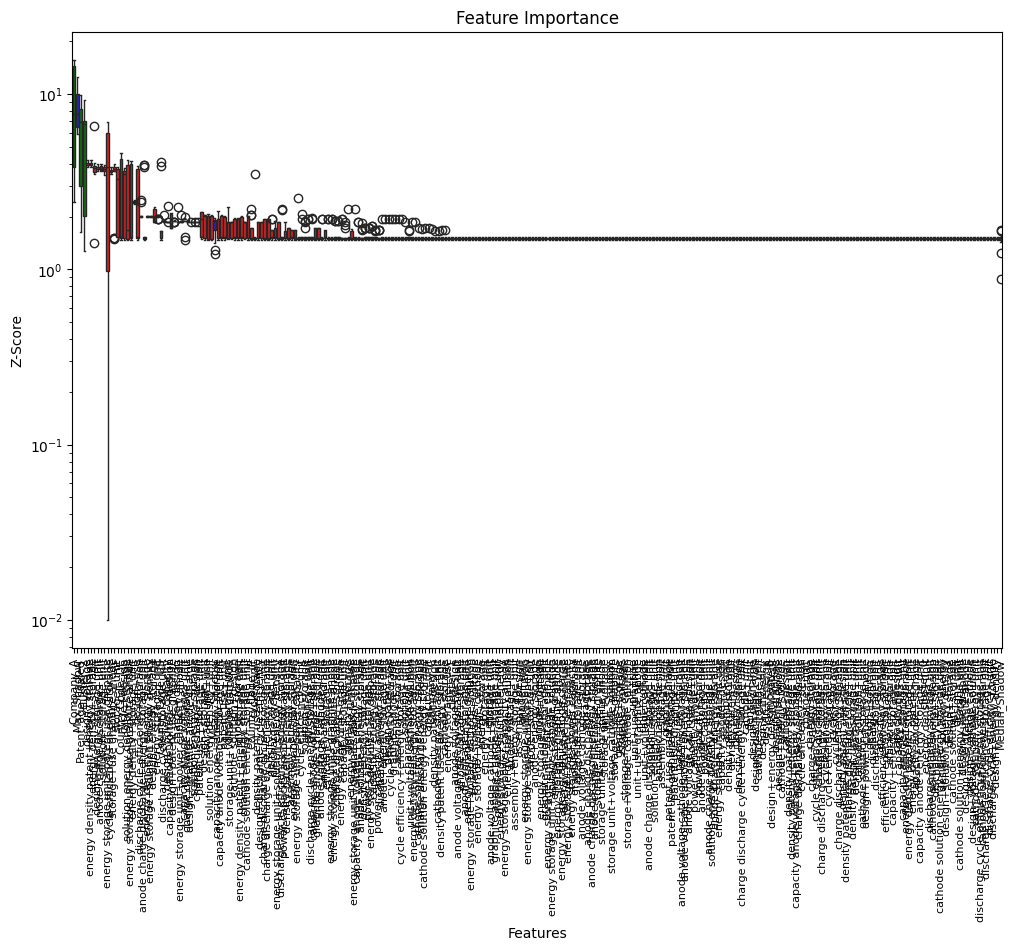

before find_top_sentences


In [ ]:
from sklearn.preprocessing import StandardScaler

#df['Grant_dummy'] = df['Grant'].replace({'YES': 1, 'NO': 0})
control_variables = control_vars #['Country.Code', 'Probable.Patent.Assignee', 'Family.Number', 'Grant_dummy', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
df['Application.Date'] = pd.to_datetime(df['Application.Date'])
df['Patent_age'] = df['Application.Date'].dt.year - df['Application.Date'].dt.year.min()
df['Year'] = df['Application.Date'].dt.year

df[control_variables].astype(str)
# max_df removed
def main(df, start=None, stop=None,  max_feat=None, min_patent_cooc=2, tfidf_threshold_percentile=50, n_components=50, n_try=60):
    '''
    Main function: outputs csv files from BorutaShap and sentences of most important co-occurrences as a xlsx file
    '''
    scaler = StandardScaler()
    results = []
    filenames = []

    non_dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() >2]]
    dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() <=2]]
    control_dummies = pd.concat([pd.get_dummies(non_dummy_controls), dummy_controls], axis=1)

    time_periods = [(min(df['Year']), max(df['Year']))] # (min(df['Year']), 1990), (1991, 2008), (2009, 2016),

    for i, (start, stop) in enumerate(time_periods):
        df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)]

        # add normalized (for each time period) patent age to controls
        control_dummies_time_period = control_dummies[(df['Year'] >= start) & (df['Year'] <= stop)].reset_index(drop=True)
        control_dummies_time_period['Patent_age_scaled'] = scaler.fit_transform(df_time_period[['Patent_age']])

        print('before get_tfidf_dummy')
        tfidf_dummy = get_tfidf_dummy(df_time_period,  max_feat=max_feat, min_patent_cooc=min_patent_cooc, tfidf_threshold_percentile=tfidf_threshold_percentile)
        print('before clustering')
        noise_dummy, cluster_dummy_grouped, cluster_dict = get_clustered_cooc_dfs(tfidf_dummy, n_components=n_components) # noise=non-clustered co-occurrences


        cluster_noise_control_dummy = pd.concat([control_dummies_time_period, noise_dummy, cluster_dummy_grouped], axis=1)

        #BorutaShap importances
        # Run BorutaShap for the current time period
        print('before BorutaShap')
        Feature_Selector_shap = run_BorutaShap(df=df_time_period, cluster_noise_control_dummy=cluster_noise_control_dummy, perc=99, n_try=n_try)#start=start, stop=stop,
        Feature_Selector_shap.plot(which_features='all')
        filename = f'feature_importance_{start}_to_{stop}'#.csv'

        Feature_Selector_shap.results_to_csv(filename=filename)

        filenames.append(filename)

        print('before find_top_sentences')
        result = find_top_sentences(file= filenames[i]+'.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)# + '.csv' #, start=start, stop=stop)

        results.append(result)

    save_as_xlsx(results)

main(df, min_patent_cooc=2, max_feat=None, tfidf_threshold_percentile=None, n_components=2, n_try=20)

In [ ]:
features = ['Patent Age', 'Family Number', 'art production technique & assembly state', 'US', 'Family Number 1']
features

['Patent Age',
 'Family Number',
 'art production technique & assembly state',
 'US',
 'Family Number 1']

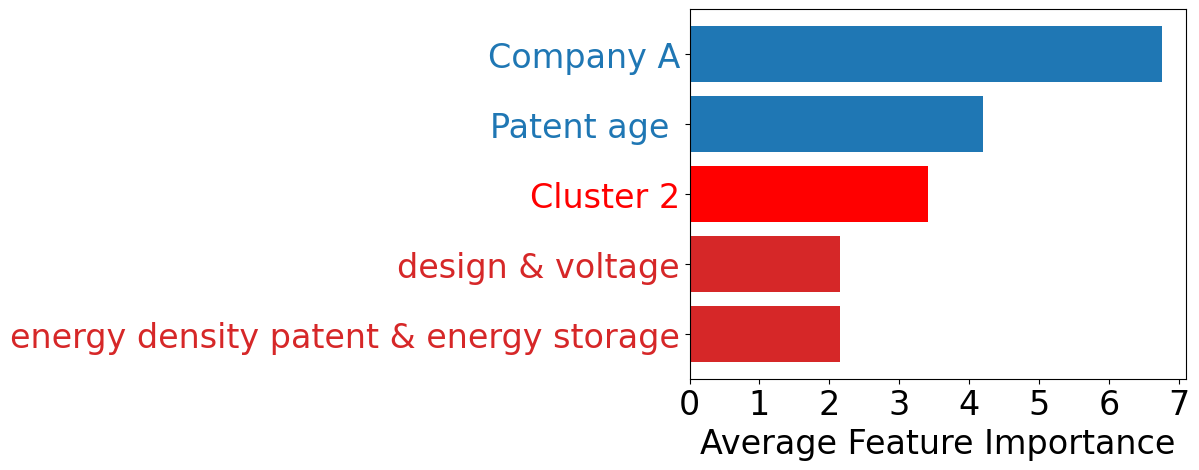

In [ ]:
# Assuming 'imps' is a DataFrame that contains your data
std_devs = imps.iloc[0:5,2]  # standard deviations
colors = ['tab:blue', 'tab:blue', 'red', 'tab:red', 'tab:red']
imps.iloc[0:5,0] = imps.iloc[0:5,0].str.replace('+', ' & ')
imps.iloc[0:5,0] = imps.iloc[0:5,0].str.replace('_', ' ')
imps.iloc[0:5,0] = imps.iloc[0:5,0].str.replace('scaled', '')
imps.iloc[0:5,0] = imps.iloc[0:5,0].str.replace('cluster', 'Cluster')

plt.barh(imps.iloc[0:5,0], imps.iloc[0:5,1], color=colors)
plt.xlabel('Average Feature Importance', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
for i, tick in enumerate(plt.gca().get_yticklabels()):
    tick.set_color(colors[i])
plt.gca().invert_yaxis()
plt.show()
